# Analysis of User Clusters

This notebook captures the user profile allocation model. 

We decided to use a Decision Tree as a framework as <br>
(1) Decision Trees act as feature extractors and allow us to allocate users with a low number of profiling questions to the profile clusters we identified.<br>
(2) Decision Trees are explainable and hence translatable to a questionaire format for the user onboarding.<br>
(3) Decision Trees are binary and hence allow easy true / false questions to be asked from the user.<br>
(4) Decision Trees yield an acceptable performance for the user profile prediction.<br>

We use a train-test-split of the dataset we used to construct the profiles. We explore different depths of a Decision Tree.

## Loading Libraries and Exploring Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree, linear_model
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score

import pydotplus
from sklearn.externals.six import StringIO 
from IPython.display import Image

/home/miber/.local/lib/python3.5/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
path_to_data = '/home/miber/data/cluster_data/df_clust_9.csv'
cluster_data = pd.read_csv(path_to_data) 

In [3]:
cluster_data.head()

,u,avg_rating,mode_rating,var_rating,cals,perc_d_fat,perc_d_sugar,perc_d_sodium,perc_d_protein,perc_d_sat_fat,...,tag__very-low-carbs,tag__vietnamese,tag__water-bath,tag__weeknight,tag__whole-chicken,tag__whole-turkey,tag__winter,tag__yams-sweet-potatoes,tag__yeast,cluster
0,0,0.961290,1.0,0.012903,0.021025,0.028423,0.013915,0.004179,0.032000,0.029955,...,0.027273,0.0,0.000000,0.000000,0.031818,0.000000,0.000000,0.000000,0.000000,profile_0
1,1,0.989744,1.0,0.003995,0.020236,0.032202,0.010476,0.003106,0.029913,0.024614,...,0.024194,0.0,0.000000,0.012097,0.000000,0.000000,0.072581,0.000000,0.012097,profile_0
2,2,0.844444,0.8,0.020513,0.024548,0.035599,0.020281,0.003856,0.027727,0.031766,...,0.000000,0.0,0.000000,0.005435,0.000000,0.000000,0.000000,0.000000,0.000000,profile_4
3,3,0.964309,1.0,0.018932,0.024385,0.034220,0.019454,0.003820,0.036677,0.028797,...,0.018275,0.0,0.002963,0.007820,0.001152,0.001317,0.024448,0.002963,0.002716,profile_0
4,4,0.877660,1.0,0.072812,0.025375,0.033930,0.023282,0.003215,0.037294,0.027398,...,0.018538,0.0,0.000000,0.006866,0.004806,0.000000,0.021627,0.002060,0.003090,profile_0


In [4]:
cluster_data.columns

Index(['u', 'avg_rating', 'mode_rating', 'var_rating', 'cals', 'perc_d_fat',
       'perc_d_sugar', 'perc_d_sodium', 'perc_d_protein', 'perc_d_sat_fat',
       ...
       'tag__very-low-carbs', 'tag__vietnamese', 'tag__water-bath',
       'tag__weeknight', 'tag__whole-chicken', 'tag__whole-turkey',
       'tag__winter', 'tag__yams-sweet-potatoes', 'tag__yeast', 'cluster'],
      dtype='object', length=298)

In [5]:
y = cluster_data.cluster
x = cluster_data.drop(['u', 'cluster', 'avg_rating', 'mode_rating', 'var_rating'], axis=1)

In [6]:
y.head()

0    profile_0
1    profile_0
2    profile_4
3    profile_0
4    profile_0
Name: cluster, dtype: object

In [7]:
y.value_counts()

profile_0    12252
profile_4     4348
profile_7     2095
profile_3     1627
profile_8     1241
profile_1     1204
profile_5     1063
profile_6      627
profile_2      619
Name: cluster, dtype: int64

In [8]:
y.shape

(25076,)

In [9]:
x.head()

,cals,perc_d_fat,perc_d_sugar,perc_d_sodium,perc_d_protein,perc_d_sat_fat,perc_d_carbs,minutes,n_steps,tag__1-day-or-more,...,tag__vegetarian,tag__very-low-carbs,tag__vietnamese,tag__water-bath,tag__weeknight,tag__whole-chicken,tag__whole-turkey,tag__winter,tag__yams-sweet-potatoes,tag__yeast
0,0.021025,0.028423,0.013915,0.004179,0.032000,0.029955,0.012994,0.000542,0.148538,0.000000,...,0.040909,0.027273,0.0,0.000000,0.000000,0.031818,0.000000,0.000000,0.000000,0.000000
1,0.020236,0.032202,0.010476,0.003106,0.029913,0.024614,0.010144,0.001472,0.168755,0.000000,...,0.012097,0.024194,0.0,0.000000,0.012097,0.000000,0.000000,0.072581,0.000000,0.012097
2,0.024548,0.035599,0.020281,0.003856,0.027727,0.031766,0.015883,0.000926,0.157895,0.000000,...,0.048913,0.000000,0.0,0.000000,0.005435,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.024385,0.034220,0.019454,0.003820,0.036677,0.028797,0.014714,0.002200,0.164559,0.001811,...,0.033339,0.018275,0.0,0.002963,0.007820,0.001152,0.001317,0.024448,0.002963,0.002716
4,0.025375,0.033930,0.023282,0.003215,0.037294,0.027398,0.016031,0.003448,0.164463,0.003433,...,0.031926,0.018538,0.0,0.000000,0.006866,0.004806,0.000000,0.021627,0.002060,0.003090


In [10]:
x.shape

(25076, 293)

## Constructing Training and Test Set (stratefied, 25% in test)

In [11]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=8462)

for train_idx, test_idx in sss.split(x, y):
    x_train = x.take(train_idx)
    y_train = y.take(train_idx)
    x_test = x.take(test_idx)
    y_test = y.take(test_idx)

In [12]:
y_test.value_counts()

profile_0    3063
profile_4    1087
profile_7     523
profile_3     407
profile_8     310
profile_1     301
profile_5     266
profile_6     157
profile_2     155
Name: cluster, dtype: int64

In [13]:
y_train.value_counts()

profile_0    9189
profile_4    3261
profile_7    1572
profile_3    1220
profile_8     931
profile_1     903
profile_5     797
profile_6     470
profile_2     464
Name: cluster, dtype: int64

In [14]:
y_train.shape

(18807,)

In [15]:
y_test.shape

(6269,)

## Fitting Decision Trees and Evaluating Results

In [16]:
dt_clf = tree.DecisionTreeClassifier(max_depth = 6)
dt_clf.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [17]:
y_pred = dt_clf.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

for name, metric in zip(['F1 score', 'Precision', 'Recall'], [f1_score, precision_score, recall_score]):
    result = metric(y_test, y_pred, average='weighted')
    print(name + ':', result)

Accuracy: 0.6069548572340087
Balanced Accuracy: 0.4410295664111348
F1 score: 0.5177107223876519
Precision: 0.47415992023249814
Recall: 0.6069548572340087


/home/miber/.local/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


A Decision Tree with depth 6 is our main model.

In [18]:
pd.Series(y_pred).value_counts()

profile_0    4721
profile_7     556
profile_8     306
profile_5     300
profile_3     220
profile_6     111
profile_2      53
profile_1       2
dtype: int64

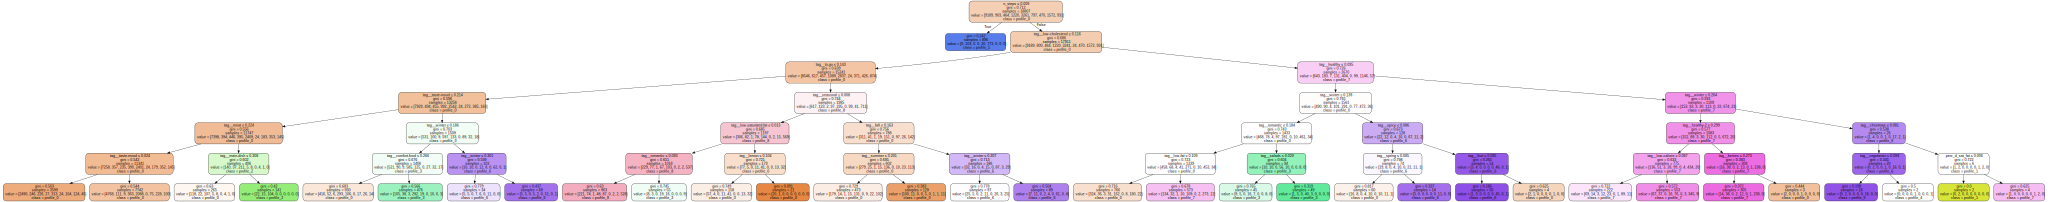

In [19]:
import graphviz
dot_data = tree.export_graphviz(dt_clf, 
 out_file=None, 
 class_names=sorted(['profile_0', 'profile_4', 'profile_7', 'profile_3', 
                     'profile_5', 'profile_8', 'profile_1', 'profile_2', 'profile_6']), # the target names.
 feature_names=x_train.columns, # the feature names.
 filled=True, # Whether to fill in the boxes with colours.
 rounded=True, # Whether to round the corners of the boxes.
 special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [20]:
from IPython.display import Image 
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())
graph.write_png("cluster_tree_2.png")

True

In [30]:
pd.Series(dt_clf.predict(x_train)).value_counts()

profile_0    14150
profile_7     1657
profile_8      963
profile_5      896
profile_3      625
profile_6      371
profile_2      141
profile_1        2
profile_4        2
dtype: int64

In [26]:
import operator
zipped = list(zip(dt_clf.feature_importances_, x_train.columns))
sorted_zip = sorted(zipped, key = operator.itemgetter(0), reverse=True) 

In [27]:
sorted_zip[:50]

[(0.29605225432208715, 'n_steps'),
 (0.20091152613486066, 'tag__low-cholesterol'),
 (0.13849803582432324, 'tag__taste-mood'),
 (0.11811269362496944, 'tag__to-go'),
 (0.04888173302383171, 'tag__meat'),
 (0.04197000275373012, 'tag__winter'),
 (0.028736236524316238, 'tag__healthy'),
 (0.020167091696175973, 'tag__seasonal'),
 (0.01795764491941638, 'tag__romantic'),
 (0.015249458227543844, 'tag__comfort-food'),
 (0.01467392067418868, 'tag__fall'),
 (0.010298870585521647, 'tag__low-fat'),
 (0.009409872299783588, 'tag__low-saturated-fat'),
 (0.007920861302323796, 'tag__summer'),
 (0.005985756197586215, 'tag__main-dish'),
 (0.005286544101119044, 'tag__healthy-2'),
 (0.004638584190206186, 'tag__low-calorie'),
 (0.004198257079737105, 'tag__spicy'),
 (0.002877001491430443, 'tag__lemon'),
 (0.0022065919320135895, 'tag__salads'),
 (0.001759458920698091, 'tag__spring'),
 (0.0010743766882984466, 'tag__berries'),
 (0.0009126972905636174, 'tag__christmas'),
 (0.0008423206320141327, 'tag__fruit'),
 (0.0

In [28]:
variables = [x[1] for x in sorted_zip if x[0] > 0]

In [34]:
dt_clf.tree_.threshold

array([ 0.00877193, -2.        ,  0.1160718 ,  0.14261501,  0.21399217,
        0.22361111,  0.02369203, -2.        , -2.        ,  0.30789474,
       -2.        , -2.        ,  0.18558674,  0.26624474, -2.        ,
       -2.        ,  0.30133928, -2.        , -2.        ,  0.0078125 ,
        0.0127551 ,  0.09282213, -2.        , -2.        ,  0.10358192,
       -2.        , -2.        ,  0.16261237,  0.20084034, -2.        ,
       -2.        ,  0.20692389, -2.        , -2.        ,  0.09549139,
        0.13859276,  0.18410365,  0.10895107, -2.        , -2.        ,
        0.0294365 , -2.        , -2.        ,  0.08608059,  0.09476745,
       -2.        , -2.        ,  0.09529211, -2.        , -2.        ,
        0.26358234,  0.29893617,  0.0867081 , -2.        , -2.        ,
        0.27329193, -2.        , -2.        ,  0.08064516,  0.0983871 ,
       -2.        , -2.        ,  0.0057714 , -2.        , -2.        ])

In [29]:
variables

['n_steps',
 'tag__low-cholesterol',
 'tag__taste-mood',
 'tag__to-go',
 'tag__meat',
 'tag__winter',
 'tag__healthy',
 'tag__seasonal',
 'tag__romantic',
 'tag__comfort-food',
 'tag__fall',
 'tag__low-fat',
 'tag__low-saturated-fat',
 'tag__summer',
 'tag__main-dish',
 'tag__healthy-2',
 'tag__low-calorie',
 'tag__spicy',
 'tag__lemon',
 'tag__salads',
 'tag__spring',
 'tag__berries',
 'tag__christmas',
 'tag__fruit',
 'tag__vegetarian',
 'perc_d_sat_fat']

In [31]:
path_to_data2 = '/home/miber/data/cluster_data/df_mod_new_data.csv'
cluster_data_raw = pd.read_csv(path_to_data2) 

In [32]:
cluster_data_raw.head()

,minutes,n_steps,n_ingredients,num_days,clean_ingredients__all-purpose flmy,clean_ingredients__allspice,clean_ingredients__almond,clean_ingredients__almond extract,clean_ingredients__american cheese,clean_ingredients__apple,...,profile_10,profile_11,profile_12,profile_13,profile_14,profile_15,profile_16,profile_17,profile_18,profile_19
0,55,11,7,4827,0.0,0.0,0.0,0.0,0.0,0.0,...,0.366642,3.614765,4.6921,4.632229,5.0,4.637026,4.62348,4.61843,4.605439,4.667145
1,30,9,6,6014,0.0,0.0,0.0,0.0,0.0,0.0,...,0.366642,3.614765,4.6921,4.632229,4.0,4.637026,4.62348,4.61843,4.605439,4.667145
2,130,6,13,5030,0.0,0.0,0.0,0.0,0.0,0.0,...,0.366642,3.614765,4.6921,4.632229,5.0,4.637026,4.62348,4.61843,4.605439,4.667145
3,45,11,11,5713,0.0,0.0,0.0,0.0,0.0,0.0,...,0.366642,3.614765,4.6921,4.632229,4.0,4.637026,4.62348,4.61843,4.605439,4.667145
4,190,5,8,5884,0.0,0.0,0.0,0.0,0.0,0.0,...,0.366642,3.614765,4.6921,4.632229,5.0,4.637026,4.62348,4.61843,4.605439,4.667145


In [60]:
var_dict = dict()

for i in variables:
    var_dict[i] = (np.min(cluster_data_raw[i]), np.max(cluster_data_raw[i]))

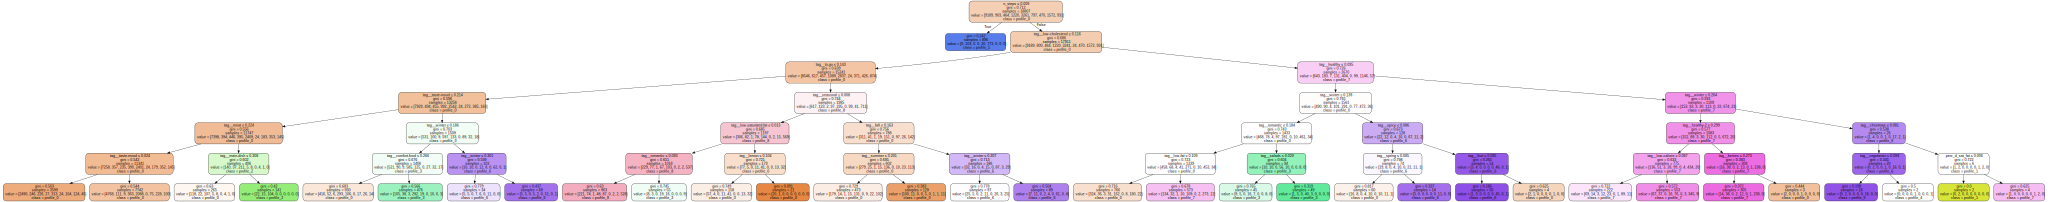

In [46]:
import graphviz
dot_data = tree.export_graphviz(dt_clf, 
 out_file=None, 
 class_names=sorted(['profile_0', 'profile_4', 'profile_7', 'profile_3', 
                     'profile_5', 'profile_8', 'profile_1', 'profile_2', 'profile_6']), # the target names.
 feature_names=x_train.columns, # the feature names.
 filled=True, # Whether to fill in the boxes with colours.
 rounded=True, # Whether to round the corners of the boxes.
 special_characters=True)
graph = graphviz.Source(dot_data)
graph

## Translating Deciusion Tree to Questionaire

In [61]:
var_dict

{'n_steps': (0, 145),
 'perc_d_sat_fat': (0.0, 10395.0),
 'tag__berries': (0.0, 1.0),
 'tag__christmas': (0.0, 1.0),
 'tag__comfort-food': (0.0, 1.0),
 'tag__fall': (0.0, 1.0),
 'tag__fruit': (0.0, 1.0),
 'tag__healthy': (0.0, 1.0),
 'tag__healthy-2': (0.0, 1.0),
 'tag__lemon': (0.0, 1.0),
 'tag__low-calorie': (0.0, 1.0),
 'tag__low-cholesterol': (0.0, 1.0),
 'tag__low-fat': (0.0, 1.0),
 'tag__low-saturated-fat': (0.0, 1.0),
 'tag__main-dish': (0.0, 1.0),
 'tag__meat': (0.0, 1.0),
 'tag__romantic': (0.0, 1.0),
 'tag__salads': (0.0, 1.0),
 'tag__seasonal': (0.0, 1.0),
 'tag__spicy': (0.0, 1.0),
 'tag__spring': (0.0, 1.0),
 'tag__summer': (0.0, 1.0),
 'tag__taste-mood': (0.0, 1.0),
 'tag__to-go': (0.0, 1.0),
 'tag__vegetarian': (0.0, 1.0),
 'tag__winter': (0.0, 1.0)}

In [47]:
dt_clf.tree_.threshold

array([ 0.00877193, -2.        ,  0.1160718 ,  0.14261501,  0.21399217,
        0.22361111,  0.02369203, -2.        , -2.        ,  0.30789474,
       -2.        , -2.        ,  0.18558674,  0.26624474, -2.        ,
       -2.        ,  0.30133928, -2.        , -2.        ,  0.0078125 ,
        0.0127551 ,  0.09282213, -2.        , -2.        ,  0.10358192,
       -2.        , -2.        ,  0.16261237,  0.20084034, -2.        ,
       -2.        ,  0.20692389, -2.        , -2.        ,  0.09549139,
        0.13859276,  0.18410365,  0.10895107, -2.        , -2.        ,
        0.0294365 , -2.        , -2.        ,  0.08608059,  0.09476745,
       -2.        , -2.        ,  0.09529211, -2.        , -2.        ,
        0.26358234,  0.29893617,  0.0867081 , -2.        , -2.        ,
        0.27329193, -2.        , -2.        ,  0.08064516,  0.0983871 ,
       -2.        , -2.        ,  0.0057714 , -2.        , -2.        ])

In [62]:
def denormalize(tag, threshold):
    mi, ma = var_dict[tag]
    return (threshold + mi)*ma

In [ ]:
from sklearn import preprocessing
def min_max_normalize(df_copy, list_columns):
    df_label_vals = pd.DataFrame(columns = ['var' , 'min', 'max'])
    for col in list_columns:
        df_label_vals = df_label_vals.append({'var' : col , 'min' : np.min(df_copy[col]), 'max' : np.max(df_copy[col])} , ignore_index=True)
        x = df_copy[col].values.reshape(-1, 1) #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        df_copy[col] = pd.DataFrame(x_scaled)
    return df_copy, df_label_vals


In [63]:
denormalize('n_steps', 0.00877193)

1.27192985

In [64]:
cluster_data_raw['n_steps'].describe()

count    231637.000000
mean          9.765499
std           5.995128
min           0.000000
25%           6.000000
50%           9.000000
75%          12.000000
max         145.000000
Name: n_steps, dtype: float64

In [65]:
denormalize('tag__low-cholesterol', 0.1160718)

0.1160718

In [66]:
cluster_data_raw['tag__low-cholesterol'].describe()

count    231525.000000
mean          0.158700
std           0.365397
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__low-cholesterol, dtype: float64

In [67]:
denormalize('tag__to-go', 0.14261501)

0.14261501

In [68]:
cluster_data_raw['tag__to-go'].describe()

count    231525.000000
mean          0.080009
std           0.271307
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__to-go, dtype: float64

In [69]:
denormalize('tag__taste-mood', 0.21399217)

0.21399217

In [70]:
cluster_data_raw['tag__taste-mood'].describe()

count    231525.000000
mean          0.225215
std           0.417725
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__taste-mood, dtype: float64

In [71]:
denormalize('tag__meat', 0.22361111)

0.22361111

In [72]:
cluster_data_raw['tag__meat'].describe()

count    231525.000000
mean          0.242056
std           0.428329
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__meat, dtype: float64

In [73]:
denormalize('tag__taste-mood', 0.02369203)

0.02369203

In [74]:
denormalize('tag__main-dish', 0.30789474)

0.30789474

In [75]:
cluster_data_raw['tag__main-dish'].describe()

count    231525.000000
mean          0.310057
std           0.462518
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: tag__main-dish, dtype: float64

In [92]:
denormalize('tag__winter', 0.18558674)

0.18558674

In [93]:
cluster_data_raw['tag__winter'].describe()

count    231525.000000
mean          0.033059
std           0.178791
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__winter, dtype: float64

In [94]:
denormalize('tag__comfort-food', 0.26624474)

0.26624474

In [95]:
cluster_data_raw['tag__comfort-food'].describe()

count    231525.000000
mean          0.112886
std           0.316454
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__comfort-food, dtype: float64

In [96]:
denormalize('tag__winter', 0.30133928)

0.30133928

In [97]:
denormalize('tag__seasonal', 0.0078125)

0.0078125

In [98]:
cluster_data_raw['tag__seasonal'].describe()

count    231525.000000
mean          0.094733
std           0.292846
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__seasonal, dtype: float64

In [99]:
denormalize('tag__low-saturated-fat', 0.0127551)

0.0127551

In [100]:
cluster_data_raw['tag__low-saturated-fat'].describe()

count    231525.000000
mean          0.135527
std           0.342287
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__low-saturated-fat, dtype: float64

In [101]:
denormalize('tag__romantic', 0.09282213)

0.09282213

In [102]:
cluster_data_raw['tag__romantic'].describe()

count    231525.000000
mean          0.022369
std           0.147881
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__romantic, dtype: float64

In [103]:
denormalize('tag__lemon', 0.10358192)

0.10358192

In [104]:
cluster_data_raw['tag__lemon'].describe()

count    231525.000000
mean          0.007364
std           0.085499
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__lemon, dtype: float64

In [105]:
denormalize('tag__fall', 0.16261237)

0.16261237

In [106]:
cluster_data_raw['tag__fall'].describe()

count    231525.000000
mean          0.033491
std           0.179915
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__fall, dtype: float64

In [107]:
denormalize('tag__summer', 0.20084034)

0.20084034

In [108]:
cluster_data_raw['tag__summer'].describe()

count    231525.000000
mean          0.043360
std           0.203667
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__summer, dtype: float64

In [109]:
denormalize('tag__winter',0.20692389)

0.20692389

In [110]:
denormalize('tag__healthy', 0.09549139)

0.09549139

In [111]:
cluster_data_raw['tag__healthy'].describe()

count    231525.000000
mean          0.174236
std           0.379313
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__healthy, dtype: float64

In [112]:
denormalize('tag__winter', 0.13859276)

0.13859276

In [114]:
denormalize('tag__romantic', 0.18410365)

0.18410365

In [115]:
denormalize('tag__low-fat', 0.10895107)

0.10895107

In [116]:
cluster_data_raw['tag__low-fat'].describe()

count    231525.000000
mean          0.095756
std           0.294258
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__low-fat, dtype: float64

In [117]:
denormalize('tag__salads', 0.0294365)

0.0294365

In [118]:
cluster_data_raw['tag__salads'].describe()

count    231525.000000
mean          0.063436
std           0.243746
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__salads, dtype: float64

In [119]:
denormalize('tag__spicy', 0.08608059)

0.08608059

In [120]:
cluster_data_raw['tag__spicy'].describe()

count    231525.000000
mean          0.035525
std           0.185104
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__spicy, dtype: float64

In [121]:
denormalize('tag__spring', 0.09476745)

0.09476745

In [122]:
cluster_data_raw['tag__spring'].describe()

count    231525.000000
mean          0.017588
std           0.131448
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__spring, dtype: float64

In [123]:
denormalize('tag__fruit', 0.09529211)

0.09529211

In [124]:
cluster_data_raw['tag__fruit'].describe()

count    231525.000000
mean          0.135294
std           0.342038
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__fruit, dtype: float64

In [125]:
denormalize('tag__winter', 0.26358234)

0.26358234

In [126]:
cluster_data_raw['tag__winter'].describe()

count    231525.000000
mean          0.033059
std           0.178791
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__winter, dtype: float64

In [127]:
denormalize('tag__healthy-2', 0.29893617)

0.29893617

In [128]:
cluster_data_raw['tag__healthy-2'].describe()

count    231525.000000
mean          0.114972
std           0.318989
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__healthy-2, dtype: float64

In [129]:
denormalize('tag__low-calorie', 0.0867081)

0.0867081

In [130]:
cluster_data_raw['tag__low-calorie'].describe()

count    231525.000000
mean          0.157344
std           0.364125
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__low-calorie, dtype: float64

In [131]:
denormalize('tag__berries', 0.27329193)

0.27329193

In [132]:
cluster_data_raw['tag__berries'].describe()

count    231525.000000
mean          0.025185
std           0.156688
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__berries, dtype: float64

In [133]:
denormalize('tag__christmas', 0.08064516)

0.08064516

In [134]:
cluster_data_raw['tag__christmas'].describe()

count    231525.000000
mean          0.035180
std           0.184234
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__christmas, dtype: float64

In [135]:
denormalize('tag__vegetarian', 0.0983871)

0.0983871

In [136]:
cluster_data_raw['tag__vegetarian'].describe()

count    231525.000000
mean          0.153983
std           0.360934
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: tag__vegetarian, dtype: float64

In [137]:
denormalize('perc_d_sat_fat', 0.0057714)

59.993703000000004

In [138]:
cluster_data_raw['perc_d_sat_fat'].describe()

count    231637.000000
mean         45.589150
std          98.235758
min           0.000000
25%           7.000000
50%          23.000000
75%          52.000000
max       10395.000000
Name: perc_d_sat_fat, dtype: float64

In [139]:
path_to_data_names = '/home/miber/data/cluster_data/df_mod_data_9clust_with_name.csv'
cluster_data_names = pd.read_csv(path_to_data_names) 

In [140]:
cluster_data_names.head()

,id,minutes,n_steps,n_ingredients,num_days,clean_ingredients__all-purpose flmy,clean_ingredients__allspice,clean_ingredients__almond,clean_ingredients__almond extract,clean_ingredients__american cheese,...,profile_2,profile_3,profile_4,profile_5,profile_6,profile_7,profile_8,name,steps,description
0,137739,55,11,7,4827,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,arriba baked winter squash mexican style,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...
1,31490,30,9,6,6014,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a bit different breakfast pizza,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...
2,112140,130,6,13,5030,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,all in the kitchen chili,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...
3,59389,45,11,11,5713,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,alouette potatoes,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea..."
4,44061,190,5,8,5884,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amish tomato ketchup for canning,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...


In [155]:
for i in ['tag__healthy', 'tag__healthy-2', 'tag__taste-mood', 'tag__romantic']:
    data = cluster_data_names[i] == 1
    print(i+':\n')
    print(cluster_data_names[data]['name'].head(30))
    print(15*'- '+'\n')
        

tag__healthy:

10                          berry  good sandwich spread
20                               cream  of spinach soup
22                              crispy crunchy  chicken
28                                      fried  potatoes
34                   healthy for them  yogurt popsicles
45                                       italian  fries
54                           leftovers  spaghetti sauce
57                 make that chicken dance  salsa pasta
60                                        mexican pasta
61                      mock a mole   low fat guacamole
65                        munch without guilt  tomatoes
81                                  red  macaroni salad
82                                 rich  hot fudge cake
93                                       sugared grapes
100    tide me over   indian chaat  simple veggie salad
134                                   ara s potato  oup
146                     almost grilled  cheese sandwich
148               anything goes  